# Text–Motion Retrieval — Version TMR Paper + MLflow

**Architectures disponibles:**
1. `transformer` — Transformer de base (learnable pos encoding, mean pooling)
2. `humanml3d` — Architecture papier TMR (sinusoidal pos, action token, GELU, 8 layers)

**Améliorations vs version précédente:**
- Deux architectures coexistent proprement, sélectionnables via `MOTION_MODEL_TYPE`
- Bug fix: validation loss avec `AlignedContrastiveLoss` (retourne tuple)
- Bug fix: métriques avancées alias (`centroid_dist`, `gap`, `recall@1`)
- Bug fix: `create_motion_encoder` if/elif corrigé
- Bug fix: double `forward` supprimé dans HumanML3DTransformer
- Config nettoyée (plus de doublons)
- `AlignedContrastiveLoss` toujours active en priorité si `USE_ALIGNED_LOSS=True`
- LSTM toujours disponible comme alternative

## 0. CONFIGURATION CENTRALE

In [ ]:
# ════════════════════════════════════════════════════════════════════════════════
# CONFIGURATION - Basée sur le papier TMR
# ════════════════════════════════════════════════════════════════════════════════

class Config:
    """Configuration basée sur le papier TMR/T-EMOS"""

    # ── CHEMINS ──────────────────────────────────────────────────────────────────
    DATA_ROOT = './data/'
    SAVE_DIR = './checkpoints/'
    MLFLOW_TRACKING_URI = './mlruns'
    MLFLOW_EXPERIMENT_NAME = 'text-motion-retrieval'

    # ── TEXT ENCODER ─────────────────────────────────────────────────────────────
    # Options: 'clip', 'distilbert'
    TEXT_ENCODER_TYPE = 'distilbert'
    DISTILBERT_MODEL = 'distilbert-base-uncased'
    FREEZE_TEXT_ENCODER = False

    # ── MOTION ENCODER ───────────────────────────────────────────────────────────
    # Options: 'lstm', 'transformer', 'humanml3d'
    # 'transformer'  → Transformer de base (learnable pos, mean pool)
    # 'humanml3d'    → Architecture TMR paper (sinusoidal pos, action token, GELU)
    MOTION_MODEL_TYPE = 'humanml3d'

    # ── DIMENSIONS ───────────────────────────────────────────────────────────────
    MOTION_DIM = 384
    EMBED_DIM = 256
    MAX_SEQ_LEN = 196

    # ── ARCHITECTURE: TRANSFORMER (commun aux deux) ───────────────────────────────
    TRANS_NHEAD = 8
    TRANS_NUM_LAYERS = 4        # 4 pour transformer basique, 8 pour humanml3d
    TRANS_DIM_FEEDFORWARD = 1024

    # ── ARCHITECTURE: LSTM (Alternative) ─────────────────────────────────────────
    LSTM_HIDDEN_DIM = 512
    LSTM_NUM_LAYERS = 2
    LSTM_BIDIRECTIONAL = True

    # ── LOSS ─────────────────────────────────────────────────────────────────────
    # USE_ALIGNED_LOSS=True  → AlignedContrastiveLoss (contrastive + MSE + uniformity)
    # USE_ALIGNED_LOSS=False → TEMOSLoss (contrastive + KL)
    USE_ALIGNED_LOSS = False
    MSE_WEIGHT = 0.15          # Poids MSE sur paires positives (force alignement)
    UNIFORMITY_WEIGHT = 0.01   # Poids uniformity (évite collapse)

    USE_TEMOS_LOSS = True      # Utilisé si USE_ALIGNED_LOSS=False
    LAMBDA_KL = 1e-5
    LAMBDA_EXTRA = 0.1

    TEMPERATURE = 0.05

    # ── MÉTRIQUES AVANCÉES ───────────────────────────────────────────────────────
    LOG_SIMILARITY_MATRIX = True
    LOG_ADVANCED_METRICS = True

    # ── RÉGULARISATION ───────────────────────────────────────────────────────────
    DROPOUT = 0.2
    WEIGHT_DECAY = 1e-3
    GRAD_CLIP = 0.5
    LABEL_SMOOTHING = 0.1

    # Augmentation
    USE_TIME_MASKING = True
    TIME_MASK_PROB = 0.25
    USE_NOISE_INJECTION = True
    NOISE_STD = 0.01
    USE_TEMPORAL_SHIFT = True
    TEMPORAL_SHIFT_MAX = 20

    # ── DUPLICATION DES MOTIONS ──────────────────────────────────────────────────
    DUPLICATE_MOTIONS = False

    # ── ENTRAÎNEMENT ─────────────────────────────────────────────────────────────
    BATCH_SIZE = 16
    EPOCHS = 30
    LEARNING_RATE = 1e-4

    USE_WARMUP = True
    WARMUP_EPOCHS = 5
    SCHEDULER_TYPE = 'cosine'

    PATIENCE = 10
    MIN_DELTA = 1e-4

    # ── VALIDATION ───────────────────────────────────────────────────────────────
    VAL_SPLIT = 0.2
    N_VIZ_SAMPLES = 100
    VIZ_EVERY_N_EPOCHS = 2

    # ── MLFLOW ───────────────────────────────────────────────────────────────────
    LOG_EVERY_N_STEPS = 10
    LOG_MODEL = True

    # ── RANDOM SEED ──────────────────────────────────────────────────────────────
    RANDOM_SEED = 42

    @classmethod
    def print_config(cls):
        print("\n" + "="*80)
        print("📋 CONFIGURATION")
        print("="*80)
        print(f"Text Encoder  : {cls.TEXT_ENCODER_TYPE.upper()}")
        print(f"Motion Encoder: {cls.MOTION_MODEL_TYPE.upper()}")
        print(f"Loss          : {'AlignedContrastive' if cls.USE_ALIGNED_LOSS else ('T-EMOS' if cls.USE_TEMOS_LOSS else 'NT-Xent')}")
        print(f"Embed Dim     : {cls.EMBED_DIM}")
        print(f"Layers        : {cls.TRANS_NUM_LAYERS}")
        print(f"Temperature   : {cls.TEMPERATURE}")
        print(f"MSE Weight    : {cls.MSE_WEIGHT if cls.USE_ALIGNED_LOSS else 'N/A'}")
        print(f"Dropout       : {cls.DROPOUT}")
        print(f"Batch Size    : {cls.BATCH_SIZE}")
        print(f"LR            : {cls.LEARNING_RATE:.0e}")
        print(f"Duplication   : {cls.DUPLICATE_MOTIONS}")
        print("="*80 + "\n")


Config.print_config()


📋 CONFIGURATION
Text Encoder  : DISTILBERT
Motion Encoder: HUMANML3D
Loss          : T-EMOS
Embed Dim     : 256
Layers        : 4
Temperature   : 0.05
MSE Weight    : N/A
Dropout       : 0.1
Batch Size    : 16
LR            : 1e-04
Duplication   : True



## 1. Imports et MLflow Setup

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
import csv
import gc
import pickle
from os.path import join as pjoin
from datetime import datetime
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import tqdm

# Text encoders
import open_clip
from transformers import DistilBertModel, DistilBertTokenizer

# PyTorch
from torch.utils.data import Dataset, DataLoader

# MLflow
import mlflow
import mlflow.pytorch

# Info NCE
try:
    from info_nce import InfoNCE
    HAS_INFO_NCE = True
except:
    HAS_INFO_NCE = False
    print("⚠️  info_nce not installed, using custom implementation")

# Setup seeds
torch.manual_seed(Config.RANDOM_SEED)
np.random.seed(Config.RANDOM_SEED)
random.seed(Config.RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Config.RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

gc.collect()
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nDevice: {device}")

from IPython import display as IPython_display
import ipywidgets as widgets
from IPython.display import display as ipy_display
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
%matplotlib inline

os.makedirs(Config.SAVE_DIR, exist_ok=True)
os.makedirs(Config.MLFLOW_TRACKING_URI, exist_ok=True)

print("✓ Imports chargés")


Device: cuda
✓ Imports chargés


In [ ]:
# ════════════════════════════════════════════════════════════════════════════════
# MLFLOW SETUP
# ════════════════════════════════════════════════════════════════════════════════

mlflow.set_tracking_uri(Config.MLFLOW_TRACKING_URI)
mlflow.set_experiment(Config.MLFLOW_EXPERIMENT_NAME)

RUN_NAME = f"{Config.TEXT_ENCODER_TYPE}_{Config.MOTION_MODEL_TYPE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

print(f"\n📊 MLflow configuré")
print(f"   Tracking URI: {Config.MLFLOW_TRACKING_URI}")
print(f"   Experiment: {Config.MLFLOW_EXPERIMENT_NAME}")
print(f"   Run name: {RUN_NAME}")
print(f"\n💡 Pour voir les résultats: mlflow ui --backend-store-uri {Config.MLFLOW_TRACKING_URI}")


📊 MLflow configuré
   Tracking URI: ./mlruns
   Experiment: text-motion-retrieval
   Run name: distilbert_humanml3d_20260219_173926

💡 Pour voir les résultats: mlflow ui --backend-store-uri ./mlruns


## 2. Fonctions de visualisation

In [ ]:
kinematic_chain = [
    [0, 2, 5, 8, 11],
    [0, 1, 4, 7, 10],
    [0, 3, 6, 9, 12, 15],
    [9, 14, 17, 19, 21],
    [9, 13, 16, 18, 20]
]

def plot_3d_motion(save_path, kinematic_tree, mp_joints, title, figsize=(10, 10), fps=30, radius=4):
    from matplotlib.animation import FuncAnimation
    from mpl_toolkits.mplot3d import Axes3D

    title_sp = title.split(' ')
    if len(title_sp) > 20:
        title = '\n'.join([' '.join(title_sp[:10]), ' '.join(title_sp[10:20]), ' '.join(title_sp[20:])])
    elif len(title_sp) > 10:
        title = '\n'.join([' '.join(title_sp[:10]), ' '.join(title_sp[10:])])

    def init():
        ax.set_xlim3d([-radius / 4, radius / 4])
        ax.set_ylim3d([0, radius / 2])
        ax.set_zlim3d([0, radius / 2])
        fig.suptitle(title, fontsize=20)
        ax.grid(b=False)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    init()

    mp_data = []
    frame_number = min([data.shape[0] for data in mp_joints])
    colors = ['red', 'green', 'black', 'red', 'blue',
              'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue',
              'darkred', 'darkred', 'darkred', 'darkred', 'darkred']
    mp_colors = [[colors[i]] * 15 for i in range(len(mp_joints))]

    for joints in mp_joints:
        data = joints.copy().reshape(len(joints), -1, 3)
        MINS = data.min(axis=0).min(axis=0)
        data[:, :, 1] -= MINS[1]
        mp_data.append({"joints": data})

    def update(index):
        for line in ax.lines:
            line.remove()
        for collection in ax.collections:
            collection.remove()
        ax.view_init(elev=120, azim=-90)
        for pid, data in enumerate(mp_data):
            for i, (chain, color) in enumerate(zip(kinematic_tree, mp_colors[pid])):
                linewidth = 4.0 if i < 5 else 2.0
                ax.plot3D(
                    data["joints"][index, chain, 0],
                    data["joints"][index, chain, 1],
                    data["joints"][index, chain, 2],
                    linewidth=linewidth, color=color
                )
        ax.set_axis_off()

    ani = FuncAnimation(fig, update, frames=frame_number, interval=1000 / fps, repeat=False)
    ani.save(save_path, fps=fps)
    plt.close()
    print(f'Animation sauvegardée : {save_path}')

In [ ]:
import seaborn as sns

def plot_and_log_similarity_matrix(text_emb, motion_emb, epoch, save_path=None):
    """Plot et log matrice de similarité"""
    text_emb_np = text_emb.detach().cpu().numpy()
    motion_emb_np = motion_emb.detach().cpu().numpy()

    sim_matrix = text_emb_np @ motion_emb_np.T

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(
        sim_matrix, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
        square=True, ax=axes[0], cbar_kws={'label': 'Cosine Similarity'},
        xticklabels=False, yticklabels=False
    )
    axes[0].set_title(f'Similarity Matrix (Epoch {epoch})', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Motion Index')
    axes[0].set_ylabel('Text Index')

    mask = np.ones_like(sim_matrix, dtype=bool)
    np.fill_diagonal(mask, False)
    sns.heatmap(
        sim_matrix, mask=mask, cmap='Greens', vmin=0, vmax=1,
        square=True, ax=axes[1], cbar_kws={'label': 'Similarity'},
        xticklabels=False, yticklabels=False
    )
    axes[1].set_title('Correct Pairs (Diagonal)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Motion Index')
    axes[1].set_ylabel('Text Index')

    plt.tight_layout()

    if save_path is None:
        save_path = f'similarity_matrix_epoch_{epoch}.png'

    plt.savefig(save_path, dpi=150, bbox_inches='tight')

    try:
        mlflow.log_artifact(save_path)
    except:
        pass

    plt.close()

    return {
        'diagonal_sim': np.mean(np.diag(sim_matrix)),
        'off_diagonal_sim': np.mean(sim_matrix[~np.eye(len(sim_matrix), dtype=bool)]),
    }

In [ ]:
def compute_advanced_metrics(text_emb, motion_emb):
    """Métriques avancées pour diagnostic du problème de séparation modale"""
    text_np = text_emb.detach().cpu().numpy()
    motion_np = motion_emb.detach().cpu().numpy()

    metrics = {}

    # Intra-modalité
    text_sim = text_np @ text_np.T
    motion_sim = motion_np @ motion_np.T
    mask = ~np.eye(len(text_np), dtype=bool)
    metrics['intra_text_sim'] = float(text_sim[mask].mean())
    metrics['intra_motion_sim'] = float(motion_sim[mask].mean())

    # Inter-modalité
    cross_sim = text_np @ motion_np.T
    metrics['inter_modal_mean'] = float(cross_sim.mean())
    metrics['inter_modal_std'] = float(cross_sim.std())

    # Distance centroïdes (cible: < 0.3 → pas de séparation modale)
    text_centroid = text_np.mean(axis=0)
    motion_centroid = motion_np.mean(axis=0)
    metrics['centroid_dist'] = float(np.linalg.norm(text_centroid - motion_centroid))

    # Recall@K
    for k in [1, 5, 10]:
        correct = sum(
            i in np.argsort(cross_sim[i])[::-1][:k]
            for i in range(len(text_np))
        )
        metrics[f'recall_at_{k}'] = correct / len(text_np)

    # Diagonal vs off-diagonal
    diagonal = float(np.diag(cross_sim).mean())
    off_diag = float(cross_sim[mask].mean())
    metrics['diagonal_sim'] = diagonal
    metrics['off_diagonal_sim'] = off_diag
    metrics['gap'] = diagonal - off_diag  # cible: > 0.7

    # Alias courts pour affichage
    metrics['recall@1'] = metrics['recall_at_1']
    metrics['recall@5'] = metrics['recall_at_5']

    return metrics

print("✓ Métriques avancées définies")

✓ Métriques avancées définies


## 3. Fonction d'évaluation

In [ ]:
def eval_recall(gt_df, pred_df, verbose=False):
    """Calcule le score Recall@K pondéré (K = 1..10)."""
    ks = list(range(1, 11))
    rank_cols = list(pred_df.columns)
    gt = gt_df["candidate"].values
    preds = pred_df[rank_cols].values
    assert len(gt) == len(preds), "Taille gt / preds incompatible"

    recalls = {k: 0 for k in ks}
    n = len(gt)
    for i in range(n):
        for k in ks:
            if gt[i] in preds[i, :k]:
                recalls[k] += 1
    for k in ks:
        recalls[k] /= n

    weights = {k: 1.0 / k for k in ks}
    weight_sum = sum(weights.values())
    final_score = sum(weights[k] * recalls[k] for k in ks) / weight_sum

    if verbose:
        for k, val in recalls.items():
            print(f'k={k} => recall@{k}={round(val, 3)}')
    return final_score

## 4. Génération val batches

In [ ]:
def generate_val_batches(data_root, save_dir, batch_size, num_batches):
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(data_root, 'train.txt')) as fd:
        train_fnames = fd.read().strip().split('\n')

    random_fnames = random.sample(train_fnames, k=batch_size * num_batches)
    random_batches = np.array(random_fnames).reshape(num_batches, batch_size)

    gt = [['query_id', 'candidate']]
    for file_idx, batch in enumerate(random_batches, start=1):
        os.makedirs(pjoin(save_dir, str(file_idx)), exist_ok=True)
        rdm_idx = random.randint(0, len(batch) - 1)
        random_text_fname = batch[rdm_idx]

        with open(pjoin(data_root, 'texts', random_text_fname + '.txt')) as fd:
            file_texts = fd.read().strip().split('\n')
            random_text = random.choice(file_texts)

        with open(pjoin(save_dir, str(file_idx), 'text.txt'), 'w') as fw:
            fw.write(random_text)

        for motion_idx, fname in enumerate(batch, start=1):
            if fname == random_text_fname:
                gt.append([file_idx, motion_idx])
            motion = np.load(pjoin(data_root, 'motions', fname + '.npy'))
            np.save(pjoin(save_dir, str(file_idx), f'motion_{motion_idx}.npy'), motion)

    with open(pjoin(save_dir, 'gt.csv'), 'w', newline='') as f:
        csv.writer(f).writerows(gt)
    print(f'Val batches sauvegardés dans {save_dir}')


data_root = Config.DATA_ROOT
save_dir = pjoin(Config.DATA_ROOT, 'val/')
if not os.path.exists(pjoin(save_dir, 'gt.csv')):
    generate_val_batches(data_root, save_dir, batch_size=32, num_batches=30)

## 5. TEXT ENCODERS (CLIP + DistilBERT)

In [ ]:
# ════════════════════════════════════════════════════════════════════════════════
# TEXT ENCODERS
# ════════════════════════════════════════════════════════════════════════════════

class DistilBertTextEncoder(nn.Module):
    """
    Text encoder basé sur DistilBERT (comme dans le papier TMR).
    """
    def __init__(self, output_dim=256, freeze=False, dropout=0.1):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(Config.DISTILBERT_MODEL)
        self.bert_dim = self.bert.config.hidden_size  # 768

        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False

        self.projection = nn.Sequential(
            nn.Linear(self.bert_dim, output_dim * 2),
            nn.LayerNorm(output_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(output_dim * 2, output_dim)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.projection(cls_output)


def create_text_encoder():
    """
    Crée le text encoder selon Config.
    Retourne (encoder, tokenizer, tokenize_function)
    """
    print(f"\n📝 Création text encoder: {Config.TEXT_ENCODER_TYPE.upper()}")

    if Config.TEXT_ENCODER_TYPE == 'distilbert':
        encoder = DistilBertTextEncoder(
            output_dim=Config.EMBED_DIM,
            freeze=Config.FREEZE_TEXT_ENCODER,
            dropout=Config.DROPOUT
        ).to(device)

        tokenizer = DistilBertTokenizer.from_pretrained(Config.DISTILBERT_MODEL)

        def tokenize_fn(texts):
            return tokenizer(
                texts,
                padding=True,
                truncation=True,
                max_length=77,
                return_tensors='pt'
            )

        print(f"   DistilBERT chargé | Freeze: {Config.FREEZE_TEXT_ENCODER}")

    elif Config.TEXT_ENCODER_TYPE == 'clip':
        clip_model, _, _ = open_clip.create_model_and_transforms(
            'ViT-B-32',
            pretrained='laion2b_s34b_b79k'
        )

        class CLIPTextWrapper(nn.Module):
            def __init__(self, clip_model, output_dim):
                super().__init__()
                self.clip = clip_model
                self.projection = nn.Linear(512, output_dim) if output_dim != 512 else nn.Identity()

            def forward(self, input_ids, attention_mask=None):
                feats = self.clip.encode_text(input_ids)
                return self.projection(feats.float())

        encoder = CLIPTextWrapper(clip_model, Config.EMBED_DIM).to(device)

        if Config.FREEZE_TEXT_ENCODER:
            for param in encoder.clip.parameters():
                param.requires_grad = False

        tokenizer = open_clip.get_tokenizer('ViT-B-32')

        def tokenize_fn(texts):
            tokens = tokenizer(texts)
            return {'input_ids': tokens, 'attention_mask': None}

        print(f"   CLIP chargé")

    else:
        raise ValueError(f"Unknown text encoder: {Config.TEXT_ENCODER_TYPE}")

    total_params = sum(p.numel() for p in encoder.parameters())
    trainable_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
    print(f"   Paramètres: {total_params:,} (entraînables: {trainable_params:,})")

    return encoder, tokenizer, tokenize_fn


text_encoder, tokenizer, tokenize_texts = create_text_encoder()


📝 Création text encoder: DISTILBERT


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


   DistilBERT chargé | Freeze: False
   Paramètres: 66,888,960 (entraînables: 66,888,960)


## 6. MOTION ENCODERS

**Deux architectures disponibles via `Config.MOTION_MODEL_TYPE`:**
- `'transformer'` — Transformer de base (learnable positional encoding, mean pooling)
- `'humanml3d'` — Architecture du papier TMR (sinusoidal pos, action token CLS-like, GELU, 8 layers)
- `'lstm'` — LSTM Bidirectionnel avec Attention

In [ ]:
# ════════════════════════════════════════════════════════════════════════════════
# MOTION ENCODERS
# ════════════════════════════════════════════════════════════════════════════════

class TransformerMotionEncoder(nn.Module):
    """
    Transformer Motion Encoder de base.
    - Positional encoding LEARNABLE
    - Mean pooling sur la séquence
    - Activation ReLU
    
    Utiliser quand: MOTION_MODEL_TYPE = 'transformer'
    """
    def __init__(self, motion_dim, embed_dim, nhead=8, num_layers=4,
                 dim_feedforward=1024, dropout=0.1, max_seq_len=196):
        super().__init__()

        self.input_proj = nn.Sequential(
            nn.Linear(motion_dim, embed_dim),
            nn.LayerNorm(embed_dim)
        )

        # Positional encoding LEARNABLE
        self.pos_embed = nn.Parameter(torch.randn(1, max_seq_len, embed_dim) * 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='relu',
            batch_first=True,
            norm_first=True
        )

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, padding_mask=None):
        B, T, _ = x.shape

        x = self.input_proj(x)
        x = x + self.pos_embed[:, :T, :]
        x = self.transformer(x, src_key_padding_mask=padding_mask)

        # Mean pooling (ignorer le padding)
        if padding_mask is not None:
            mask = (~padding_mask).float().unsqueeze(-1)
            x = (x * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        else:
            x = x.mean(dim=1)

        x = self.norm(x)
        x = self.dropout(x)
        return x


class HumanML3DTransformer(nn.Module):
    """
    Architecture du papier TMR/HumanML3D.
    Différences vs TransformerMotionEncoder:
    - Positional encoding SINUSOIDAL (plus stable, pas de paramètres)
    - Action token (comme [CLS] dans BERT) → pas besoin de pooling
    - Activation GELU (plus smooth que ReLU)
    - 8 layers par défaut

    Utiliser quand: MOTION_MODEL_TYPE = 'humanml3d'
    """
    def __init__(self, motion_dim=384, embed_dim=256, num_layers=8, nhead=8,
                 dim_feedforward=1024, dropout=0.1, max_seq_len=196):
        super().__init__()

        self.embed_dim = embed_dim

        # Input projection (pas de LayerNorm ici, la norme vient du transformer)
        self.input_proj = nn.Linear(motion_dim, embed_dim)

        # Positional encoding SINUSOIDAL (buffer, non-entraînable)
        self.register_buffer(
            'pos_encoding',
            self._create_sinusoidal_encoding(max_seq_len, embed_dim)
        )

        # Transformer avec GELU
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
            norm=nn.LayerNorm(embed_dim)
        )

        # Action token (comme [CLS] dans BERT)
        self.action_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)

        # Output projection
        self.output_proj = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

    def _create_sinusoidal_encoding(self, max_len, d_model):
        """Positional encoding sinusoidal (Attention is All You Need)"""
        position = torch.arange(max_len).unsqueeze(1).float()
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() *
            (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x, padding_mask=None):
        B, T, _ = x.shape

        # Input projection + positional encoding sinusoidal
        x = self.input_proj(x) + self.pos_encoding[:, :T, :]

        # Prepend action token (CLS-like)
        action_tokens = self.action_token.expand(B, -1, -1)
        x = torch.cat([action_tokens, x], dim=1)  # (B, T+1, D)

        # Mettre à jour le padding mask pour inclure l'action token
        if padding_mask is not None:
            action_mask = torch.zeros(B, 1, dtype=torch.bool, device=x.device)
            padding_mask = torch.cat([action_mask, padding_mask], dim=1)

        # Transformer
        x = self.transformer(x, src_key_padding_mask=padding_mask)

        # Utiliser l'action token comme représentation finale (position 0)
        return self.output_proj(x[:, 0, :])


class LSTMMotionEncoder(nn.Module):
    """LSTM Bidirectionnel avec Attention."""
    def __init__(self, motion_dim, hidden_dim, embed_dim, num_layers=2,
                 dropout=0.1, bidirectional=True):
        super().__init__()

        self.input_proj = nn.Sequential(
            nn.Linear(motion_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        lstm_hidden = (hidden_dim // 2) if bidirectional else hidden_dim
        self.lstm = nn.LSTM(
            input_size=hidden_dim // 2,
            hidden_size=lstm_hidden,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        lstm_out_dim = hidden_dim if bidirectional else lstm_hidden

        self.attention = nn.Sequential(
            nn.Linear(lstm_out_dim, lstm_out_dim // 2),
            nn.Tanh(),
            nn.Linear(lstm_out_dim // 2, 1)
        )

        self.output_proj = nn.Sequential(
            nn.LayerNorm(lstm_out_dim),
            nn.Dropout(dropout),
            nn.Linear(lstm_out_dim, embed_dim)
        )

    def forward(self, x, padding_mask=None):
        x = self.input_proj(x)
        lstm_out, _ = self.lstm(x)

        attn_scores = self.attention(lstm_out)
        if padding_mask is not None:
            attn_scores = attn_scores.masked_fill(padding_mask.unsqueeze(-1), -1e9)

        attn_weights = F.softmax(attn_scores, dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)

        return self.output_proj(context)


def create_motion_encoder():
    """Factory pour créer le motion encoder selon Config.MOTION_MODEL_TYPE."""
    model_type = Config.MOTION_MODEL_TYPE.lower()

    print(f"\n🏗️  Création motion encoder: {model_type.upper()}")

    if model_type == 'transformer':
        encoder = TransformerMotionEncoder(
            motion_dim=Config.MOTION_DIM,
            embed_dim=Config.EMBED_DIM,
            nhead=Config.TRANS_NHEAD,
            num_layers=Config.TRANS_NUM_LAYERS,
            dim_feedforward=Config.TRANS_DIM_FEEDFORWARD,
            dropout=Config.DROPOUT,
            max_seq_len=Config.MAX_SEQ_LEN
        )
        print("   Learnable pos encoding | Mean pooling | ReLU")

    elif model_type == 'humanml3d':
        encoder = HumanML3DTransformer(
            motion_dim=Config.MOTION_DIM,
            embed_dim=Config.EMBED_DIM,
            num_layers=Config.TRANS_NUM_LAYERS,
            nhead=Config.TRANS_NHEAD,
            dim_feedforward=Config.TRANS_DIM_FEEDFORWARD,
            dropout=Config.DROPOUT,
            max_seq_len=Config.MAX_SEQ_LEN
        )
        print("   Sinusoidal pos encoding | Action token (CLS) | GELU")

    elif model_type == 'lstm':
        encoder = LSTMMotionEncoder(
            motion_dim=Config.MOTION_DIM,
            hidden_dim=Config.LSTM_HIDDEN_DIM,
            embed_dim=Config.EMBED_DIM,
            num_layers=Config.LSTM_NUM_LAYERS,
            dropout=Config.DROPOUT,
            bidirectional=Config.LSTM_BIDIRECTIONAL
        )
        print("   Bidirectional LSTM | Attention pooling")

    else:
        raise ValueError(f"Unsupported model type: '{model_type}'. Use 'transformer', 'humanml3d', or 'lstm'.")

    encoder = encoder.to(device)
    total_params = sum(p.numel() for p in encoder.parameters())
    print(f"   Paramètres: {total_params:,}")

    return encoder


# is_vae_model est toujours False (VAE non supporté dans cette version)
is_vae_model = False
motion_encoder = create_motion_encoder()
print("\n✓ Encodeurs créés")


🏗️  Création motion encoder: HUMANML3D
   Sinusoidal pos encoding | Action token (CLS) | GELU
   Paramètres: 3,324,672

✓ Encodeurs créés


C:\Users\luceu\AppData\Local\Temp\ipykernel_35380\1504364071.py:96: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer = nn.TransformerEncoder(


## 7. Dataset avec augmentation renforcée

In [ ]:
# ════════════════════════════════════════════════════════════════════════════════
# PREPROCESSING avec AUGMENTATION RENFORCÉE
# ════════════════════════════════════════════════════════════════════════════════

def compute_global_stats(fnames, motion_dir, n_samples=500):
    sample = random.sample(fnames, min(n_samples, len(fnames)))
    all_frames = [np.load(os.path.join(motion_dir, f + '.npy')) for f in sample]
    all_frames = np.vstack(all_frames)
    return all_frames.mean(axis=0), all_frames.std(axis=0) + 1e-6


def preprocess_motion(motion, global_mean=None, global_std=None, max_len=None, augment=False):
    """
    Prétraite avec augmentation renforcée.
    """
    if max_len is None:
        max_len = Config.MAX_SEQ_LEN

    if global_mean is not None and global_std is not None:
        motion = (motion - global_mean) / global_std

    if augment:
        # 1. Time masking
        if Config.USE_TIME_MASKING and Config.TIME_MASK_PROB > 0:
            mask = np.random.random(len(motion)) < Config.TIME_MASK_PROB
            motion[mask] = 0

        # 2. Noise injection
        if Config.USE_NOISE_INJECTION and Config.NOISE_STD > 0:
            noise = np.random.normal(0, Config.NOISE_STD, motion.shape)
            motion = motion + noise

        # 3. Temporal shift
        if Config.USE_TEMPORAL_SHIFT and Config.TEMPORAL_SHIFT_MAX > 0:
            shift = np.random.randint(-Config.TEMPORAL_SHIFT_MAX, Config.TEMPORAL_SHIFT_MAX + 1)
            if shift != 0:
                motion = np.roll(motion, shift, axis=0)

    T, F = motion.shape
    mask = np.zeros(max_len, dtype=bool)

    if T >= max_len:
        if augment and T > max_len:
            start_idx = np.random.randint(0, T - max_len + 1)
            motion = motion[start_idx:start_idx + max_len]
        else:
            motion = motion[:max_len]
    else:
        mask[T:] = True
        motion = np.vstack([motion, np.zeros((max_len - T, F), dtype=np.float32)])

    return torch.from_numpy(motion).float(), torch.from_numpy(mask)


class TextMotionDataset(Dataset):
    def __init__(self, fnames, data_root, global_mean, global_std,
                 max_seq_len=None, duplicate_motions=None, augment=False):
        self.motion_dir = pjoin(data_root, 'motions')
        self.text_dir = pjoin(data_root, 'texts')
        self.max_seq_len = max_seq_len or Config.MAX_SEQ_LEN
        self.global_mean = global_mean
        self.global_std = global_std
        self.augment = augment
        self.duplicate_motions = duplicate_motions if duplicate_motions is not None else Config.DUPLICATE_MOTIONS

        self.samples = []

        for fname in fnames:
            text_path = pjoin(self.text_dir, fname + '.txt')
            if os.path.exists(text_path):
                with open(text_path, 'r', encoding='utf-8') as f:
                    texts = [l.strip() for l in f.readlines() if l.strip()]

                if self.duplicate_motions:
                    for t in texts:
                        self.samples.append((fname, t))
                else:
                    self.samples.append((fname, texts))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname, text_data = self.samples[idx]

        if self.duplicate_motions:
            text = text_data
        else:
            text = random.choice(text_data)

        motion_raw = np.load(pjoin(self.motion_dir, fname + '.npy'))
        motion, pad_mask = preprocess_motion(
            motion_raw, self.global_mean, self.global_std,
            max_len=self.max_seq_len, augment=self.augment
        )

        return text, motion, pad_mask


print("✓ Dataset et preprocessing définis")

✓ Dataset et preprocessing définis


In [ ]:
# Charger les données
data_root = Config.DATA_ROOT
with open(pjoin(data_root, 'train.txt')) as f:
    all_fnames = f.read().strip().split('\n')
print(f'Total fichiers train : {len(all_fnames)}')

motion_dir_path = pjoin(data_root, 'motions')
GLOBAL_MEAN, GLOBAL_STD = compute_global_stats(all_fnames, motion_dir_path)
print(f'Stats globales calculées. Mean shape: {GLOBAL_MEAN.shape}')

train_fnames, val_fnames = train_test_split(
    all_fnames, test_size=Config.VAL_SPLIT, random_state=Config.RANDOM_SEED
)
print(f'Train : {len(train_fnames)} | Val : {len(val_fnames)}')

train_dataset = TextMotionDataset(
    train_fnames, data_root, GLOBAL_MEAN, GLOBAL_STD,
    duplicate_motions=Config.DUPLICATE_MOTIONS,
    augment=True
)

val_dataset = TextMotionDataset(
    val_fnames, data_root, GLOBAL_MEAN, GLOBAL_STD,
    duplicate_motions=False,
    augment=False
)


def collate_fn(batch):
    texts, motions, masks = zip(*batch)
    text_batch = tokenize_texts(list(texts))
    text_batch = {k: v.to(device) if v is not None else None for k, v in text_batch.items()}
    motion_batch = torch.stack(motions).to(device)
    mask_batch = torch.stack(masks).to(device)
    return text_batch, motion_batch, mask_batch


train_loader = DataLoader(
    train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True,
    drop_last=True, collate_fn=collate_fn, num_workers=0
)

val_loader = DataLoader(
    val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False,
    drop_last=False, collate_fn=collate_fn, num_workers=0
)

print(f'Batches train : {len(train_loader)} | Batches val : {len(val_loader)}')
print(f'Samples train : {len(train_dataset)} | Samples val : {len(val_dataset)}')

Total fichiers train : 6018
Stats globales calculées. Mean shape: (384,)
Train : 4814 | Val : 1204
Batches train : 902 | Batches val : 76
Samples train : 14442 | Samples val : 1204


## 8. LOSS FUNCTIONS

**Deux losses disponibles:**
- `AlignedContrastiveLoss` (si `USE_ALIGNED_LOSS=True`) : contrastive + MSE paires + uniformity → résout la séparation modale
- `TEMOSLoss` (si `USE_ALIGNED_LOSS=False`) : contrastive + KL (papier)

**Pourquoi AlignedContrastiveLoss résout la séparation t-SNE:**
La MSE loss force chaque paire (text_i, motion_i) à avoir des embeddings proches dans l'espace L2, en plus de la loss contrastive qui ne fait que séparer les paires incorrectes.

In [ ]:
# ════════════════════════════════════════════════════════════════════════════════
# LOSS FUNCTIONS
# ════════════════════════════════════════════════════════════════════════════════

class NTXentLoss(nn.Module):
    """NT-Xent (Normalized Temperature-scaled Cross Entropy)."""
    def __init__(self, temperature=0.05):
        super().__init__()
        self.temperature = temperature

    def forward(self, text_emb, motion_emb):
        batch_size = text_emb.shape[0]
        logits = (text_emb @ motion_emb.T) / self.temperature
        labels = torch.arange(batch_size, device=text_emb.device)
        loss_t2m = F.cross_entropy(logits, labels)
        loss_m2t = F.cross_entropy(logits.T, labels)
        return (loss_t2m + loss_m2t) / 2


class TEMOSLoss(nn.Module):
    """
    Loss T-EMOS du papier: L = L_R + λ_KL * L_KL + λ_E * L_E
    Retourne (total_loss, loss_dict) pour compatibilité.
    """
    def __init__(self, temperature=0.05, lambda_kl=1e-5, lambda_extra=0.1):
        super().__init__()
        self.contrastive_loss = NTXentLoss(temperature)
        self.lambda_kl = lambda_kl
        self.lambda_extra = lambda_extra

    def forward(self, text_emb, motion_emb, mu=None, logvar=None, extra_loss=None):
        loss_r = self.contrastive_loss(text_emb, motion_emb)
        loss_dict = {'contrastive': loss_r.item()}
        total_loss = loss_r

        if mu is not None and logvar is not None:
            loss_kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
            loss_dict['kl'] = loss_kl.item()
            total_loss = total_loss + self.lambda_kl * loss_kl

        if extra_loss is not None:
            loss_dict['extra'] = extra_loss.item()
            total_loss = total_loss + self.lambda_extra * extra_loss

        loss_dict['total'] = total_loss.item()
        return total_loss, loss_dict


class AlignedContrastiveLoss(nn.Module):
    """
    Loss avec alignement forcé pour résoudre la séparation modale.
    Combine:
    1. Contrastive loss (CLIP-style) — sépare paires incorrectes
    2. MSE loss sur paires positives — FORCE l'alignement exact
    3. Uniformity loss — distribution uniforme sur la sphère

    Retourne (total_loss, loss_dict) pour compatibilité avec le training loop.
    """
    def __init__(self, temperature=0.05, mse_weight=0.15, uniformity_weight=0.01):
        super().__init__()
        self.temperature = temperature
        self.mse_weight = mse_weight
        self.uniformity_weight = uniformity_weight

    def forward(self, text_emb, motion_emb):
        # Normalisation L2 (embeddings sur la sphère unitaire)
        text_norm = F.normalize(text_emb, dim=-1)
        motion_norm = F.normalize(motion_emb, dim=-1)

        batch_size = text_norm.shape[0]

        # 1. Contrastive loss bidirectionnelle
        logits = (text_norm @ motion_norm.T) / self.temperature
        labels = torch.arange(batch_size, device=text_norm.device)
        loss_t2m = F.cross_entropy(logits, labels)
        loss_m2t = F.cross_entropy(logits.T, labels)
        contrastive_loss = (loss_t2m + loss_m2t) / 2

        # 2. MSE sur paires positives (force alignement)
        mse_loss = F.mse_loss(text_norm, motion_norm)

        # 3. Uniformity loss
        def _uniformity(z):
            if len(z) < 2:
                return torch.tensor(0.0, device=z.device)
            dists = torch.pdist(z, p=2)
            return torch.log(torch.exp(-2 * dists).mean() + 1e-8)

        uniformity = (_uniformity(text_norm) + _uniformity(motion_norm)) / 2

        total_loss = (
            contrastive_loss +
            self.mse_weight * mse_loss +
            self.uniformity_weight * uniformity
        )

        loss_dict = {
            'contrastive': contrastive_loss.item(),
            'mse': mse_loss.item(),
            'uniformity': uniformity.item(),
            'total': total_loss.item()
        }

        return total_loss, loss_dict


# ── Création de la loss selon Config ─────────────────────────────────────────
if Config.USE_ALIGNED_LOSS:
    loss_fn = AlignedContrastiveLoss(
        temperature=Config.TEMPERATURE,
        mse_weight=Config.MSE_WEIGHT,
        uniformity_weight=Config.UNIFORMITY_WEIGHT
    )
    print(f"✓ AlignedContrastiveLoss (T={Config.TEMPERATURE}, MSE_W={Config.MSE_WEIGHT}, U_W={Config.UNIFORMITY_WEIGHT})")
    LOSS_RETURNS_TUPLE = True

elif Config.USE_TEMOS_LOSS:
    loss_fn = TEMOSLoss(
        temperature=Config.TEMPERATURE,
        lambda_kl=Config.LAMBDA_KL,
        lambda_extra=Config.LAMBDA_EXTRA
    )
    print(f"✓ TEMOSLoss (T={Config.TEMPERATURE}, λ_KL={Config.LAMBDA_KL:.0e})")
    LOSS_RETURNS_TUPLE = True

else:
    loss_fn = NTXentLoss(temperature=Config.TEMPERATURE)
    print(f"✓ NTXentLoss (T={Config.TEMPERATURE})")
    LOSS_RETURNS_TUPLE = False

print(f"   LOSS_RETURNS_TUPLE = {LOSS_RETURNS_TUPLE}")

✓ TEMOSLoss (T=0.05, λ_KL=1e-05)
   LOSS_RETURNS_TUPLE = True


## 9. Fonctions d'encodage

In [ ]:
def encode_text(text_batch):
    """
    Encode le texte et normalise L2.
    text_batch: dict avec 'input_ids' et 'attention_mask'
    """
    text_feats = text_encoder(**text_batch)
    return F.normalize(text_feats, dim=-1)


def encode_motion(motion_batch, mask_batch=None):
    """
    Encode la motion et normalise L2.
    Toujours retourne un seul tensor (pas de VAE dans cette version).
    """
    output = motion_encoder(motion_batch, mask_batch)
    if isinstance(output, tuple):
        output = output[0]
    return F.normalize(output, dim=-1)


def compute_loss(text_emb, motion_emb):
    """
    Calcule la loss et retourne (total_loss, loss_dict) uniformément.
    Gère les deux cas: loss retournant un tuple ou un scalaire.
    """
    if LOSS_RETURNS_TUPLE:
        loss, loss_dict = loss_fn(text_emb, motion_emb)
    else:
        loss = loss_fn(text_emb, motion_emb)
        loss_dict = {'total': loss.item(), 'contrastive': loss.item()}
    return loss, loss_dict


print("✓ Fonctions d'encodage définies")

✓ Fonctions d'encodage définies


## 10. Optimiseur avec Warmup

In [ ]:
# ════════════════════════════════════════════════════════════════════════════════
# OPTIMISEUR ET SCHEDULER avec WARMUP
# ════════════════════════════════════════════════════════════════════════════════

params_to_optimize = list(motion_encoder.parameters()) + list(text_encoder.parameters())

optimizer = optim.AdamW(
    params_to_optimize,
    lr=Config.LEARNING_RATE,
    weight_decay=Config.WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

if Config.USE_WARMUP:
    from torch.optim.lr_scheduler import LambdaLR

    def lr_lambda(epoch):
        if epoch < Config.WARMUP_EPOCHS:
            return (epoch + 1) / Config.WARMUP_EPOCHS
        else:
            progress = (epoch - Config.WARMUP_EPOCHS) / max(1, Config.EPOCHS - Config.WARMUP_EPOCHS)
            return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = LambdaLR(optimizer, lr_lambda)
    print(f"\n✓ Scheduler: Warmup ({Config.WARMUP_EPOCHS} epochs) + Cosine decay")
else:
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=Config.EPOCHS, eta_min=Config.LEARNING_RATE / 100
    )
    print(f"\n✓ Scheduler: Cosine Annealing")

print(f"   LR: {Config.LEARNING_RATE:.0e}, WD: {Config.WEIGHT_DECAY:.0e}")


✓ Scheduler: Warmup (5 epochs) + Cosine decay
   LR: 1e-04, WD: 1e-03


## 11. Dashboard fonctions

In [ ]:
# ════════════════════════════════════════════════════════════════════════════════
# DASHBOARD LIVE
# ════════════════════════════════════════════════════════════════════════════════

def get_live_embeddings(fnames_subset):
    text_encoder.eval()
    motion_encoder.eval()
    t_embs, m_embs = [], []

    with torch.no_grad():
        for fname in fnames_subset:
            with open(pjoin(data_root, 'texts', fname + '.txt')) as f:
                txts = f.read().strip().split('\n')

            text_batch = tokenize_texts([txts[0]])
            text_batch = {k: v.to(device) if v is not None else None for k, v in text_batch.items()}
            t_emb = encode_text(text_batch)

            motion_raw = np.load(pjoin(data_root, 'motions', fname + '.npy'))
            mot, msk = preprocess_motion(motion_raw, GLOBAL_MEAN, GLOBAL_STD)
            mot = mot.unsqueeze(0).to(device)
            msk = msk.unsqueeze(0).to(device)
            m_emb = encode_motion(mot, msk)

            t_embs.append(t_emb.cpu().numpy().squeeze())
            m_embs.append(m_emb.cpu().numpy().squeeze())

    return np.array(t_embs), np.array(m_embs), fnames_subset


def compute_cosine_stats(text_arr, motion_arr):
    sim_matrix = text_arr @ motion_arr.T
    N = len(text_arr)
    diag_sims = sim_matrix[np.arange(N), np.arange(N)]
    mask_off = ~np.eye(N, dtype=bool)
    offdiag_sims = sim_matrix[mask_off]
    return float(diag_sims.mean()), float(offdiag_sims.mean())


def render_dashboard(train_losses, val_losses, cos_correct_hist, cos_wrong_hist,
                     text_arr, motion_arr, epoch, best_epoch):
    combined = np.vstack([text_arr, motion_arr])
    tsne = TSNE(n_components=2, perplexity=min(15, len(text_arr) // 2),
                random_state=42, verbose=0)
    proj = tsne.fit_transform(combined)
    N = len(text_arr)
    t2d, m2d = proj[:N], proj[N:]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(train_losses, label='Train', linewidth=2)
    axes[0].plot(val_losses, label='Val', linewidth=2)
    axes[0].axvline(best_epoch, color='red', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'Loss (Epoch {epoch})', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    epochs_hist = list(range(1, len(cos_correct_hist) + 1))
    axes[1].plot(epochs_hist, cos_correct_hist, label='Correct', linewidth=2, color='green')
    axes[1].plot(epochs_hist, cos_wrong_hist, label='Incorrect', linewidth=2, color='red')
    gap = [c - w for c, w in zip(cos_correct_hist, cos_wrong_hist)]
    axes[1].plot(epochs_hist, gap, label='Gap', linestyle='--', linewidth=2, color='blue')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Cosine Similarity')
    axes[1].set_title('Alignment Metrics', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    axes[2].scatter(t2d[:, 0], t2d[:, 1], alpha=0.6, s=40, c='steelblue',
                    edgecolors='black', linewidth=0.5, label='Text')
    axes[2].scatter(m2d[:, 0], m2d[:, 1], alpha=0.6, s=40, c='tomato',
                    edgecolors='black', linewidth=0.5, label='Motion')
    for i in range(min(20, N)):
        axes[2].plot([t2d[i, 0], m2d[i, 0]], [t2d[i, 1], m2d[i, 1]],
                     'gray', alpha=0.3, linewidth=0.8)
    axes[2].set_title('t-SNE Embedding', fontweight='bold')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    IPython_display.clear_output(wait=True)
    IPython_display.display(fig)
    plt.close()


N_VIZ_LIVE = Config.N_VIZ_SAMPLES
VIZ_EVERY = Config.VIZ_EVERY_N_EPOCHS
viz_fnames_live = random.sample(train_fnames, min(N_VIZ_LIVE, len(train_fnames)))

print('✓ Dashboard ready')

✓ Dashboard ready


## 12. TRAINING LOOP avec MLflow

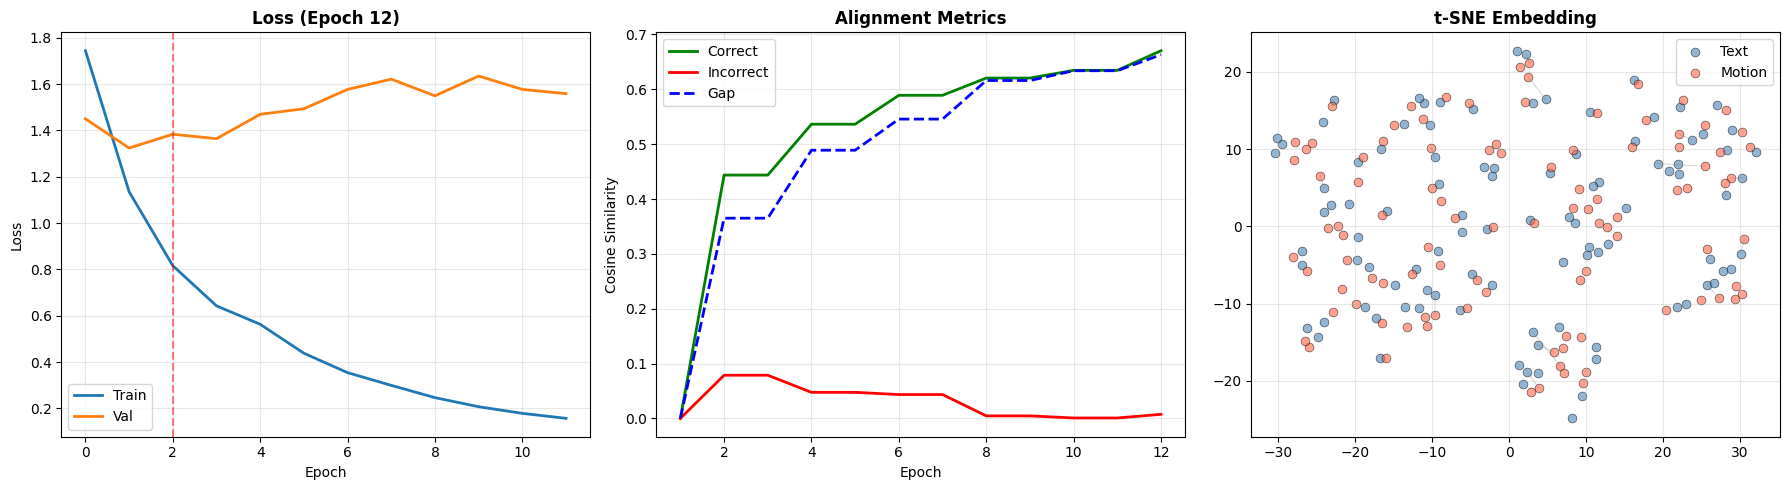

Ep  12 | Train=0.1573 | Val=1.5586 | Cos+=0.670 Cos-=0.007 Gap=0.663 | Pat=10/10

Early stopping (ep 12). Best val: 1.3238 (ep 2)


2026/02/19 20:43:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/19 20:43:33 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.
2026/02/19 20:43:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.10.0+cu130) contains a local version label (+cu130). MLflow logged a pip requirement for this package as 'torch==2.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/02/19 20:43:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.10.0+cu130) contains a local version label (+cu130).


✓ Training terminé. Best model loaded (ep 2, val=1.3238)

📊 MLflow Run ID: 9112d77216e44938b060574aac30173b
   View results: mlflow ui --backend-store-uri ./mlruns


In [ ]:
# ════════════════════════════════════════════════════════════════════════════════
# TRAINING LOOP avec MLflow TRACKING
# ════════════════════════════════════════════════════════════════════════════════

EPOCHS = Config.EPOCHS
PATIENCE = Config.PATIENCE

train_losses     = []
val_losses       = []
cos_correct_hist = []
cos_wrong_hist   = []
best_val_loss    = float('inf')
best_recall      = 0.0
best_epoch       = 1
patience_count   = 0
start_epoch      = 1
global_step      = 0
_existing_run_id = None  # Rempli par cellule Reprise si necessaire

_run_ctx = (
    mlflow.start_run(run_id=_existing_run_id)
    if _existing_run_id
    else mlflow.start_run(run_name=RUN_NAME)
)
with _run_ctx as run:

    # Logger la config
    config_dict = {k: v for k, v in vars(Config).items()
                   if not k.startswith('_') and not callable(v)}
    mlflow.log_params(config_dict)

    print(f"\n" + "="*80)
    print(f"DÉBUT DE L'ENTRAÎNEMENT")
    print(f"Motion Encoder : {Config.MOTION_MODEL_TYPE.upper()}")
    print(f"Loss           : {'AlignedContrastive' if Config.USE_ALIGNED_LOSS else 'TEMOS/NTXent'}")
    print(f"MLflow Run ID  : {run.info.run_id}")
    print("="*80 + "\n")

    global_step = 0

    for epoch in range(start_epoch, EPOCHS + 1):

        # ── TRAIN ────────────────────────────────────────────────────────────────
        text_encoder.train()
        motion_encoder.train()
        epoch_loss = 0.0
        epoch_metrics = {'contrastive': 0.0, 'mse': 0.0, 'uniformity': 0.0}

        pbar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch}/{EPOCHS}', leave=False)

        for batch_idx, (text_batch, motion_batch, mask_batch) in enumerate(pbar):
            optimizer.zero_grad()

            text_emb = encode_text(text_batch)
            motion_emb = encode_motion(motion_batch, mask_batch)

            loss, loss_dict = compute_loss(text_emb, motion_emb)

            loss.backward()
            if Config.GRAD_CLIP > 0:
                torch.nn.utils.clip_grad_norm_(
                    list(text_encoder.parameters()) + list(motion_encoder.parameters()),
                    Config.GRAD_CLIP
                )
            optimizer.step()

            epoch_loss += loss_dict['total']
            for k in epoch_metrics:
                if k in loss_dict:
                    epoch_metrics[k] += loss_dict[k]

            global_step += 1
            if global_step % Config.LOG_EVERY_N_STEPS == 0:
                mlflow.log_metric('train_loss_step', loss_dict['total'], step=global_step)
                mlflow.log_metric('lr', optimizer.param_groups[0]['lr'], step=global_step)

            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        avg_train = epoch_loss / len(train_loader)
        train_losses.append(avg_train)

        # ── VALIDATION ───────────────────────────────────────────────────────────
        text_encoder.eval()
        motion_encoder.eval()
        val_loss = 0.0

        with torch.no_grad():
            for text_batch, motion_batch, mask_batch in val_loader:
                text_emb = encode_text(text_batch)
                motion_emb = encode_motion(motion_batch, mask_batch)
                # Utiliser compute_loss pour gérer tuple/scalaire uniformément
                loss, _ = compute_loss(text_emb, motion_emb)
                val_loss += loss.item()

        avg_val = val_loss / len(val_loader)
        val_losses.append(avg_val)

        # ── MÉTRIQUES AVANCÉES ───────────────────────────────────────────────────
        if epoch % VIZ_EVERY == 0 and Config.LOG_ADVANCED_METRICS:
            with torch.no_grad():
                all_text_embs, all_motion_embs = [], []

                for text_batch, motion_batch, mask_batch in val_loader:
                    t_emb = encode_text(text_batch)
                    m_emb = encode_motion(motion_batch, mask_batch)
                    all_text_embs.append(t_emb)
                    all_motion_embs.append(m_emb)

                all_text_cat = torch.cat(all_text_embs)
                all_motion_cat = torch.cat(all_motion_embs)

                adv_metrics = compute_advanced_metrics(all_text_cat, all_motion_cat)

                # Logger dans MLflow (sans les alias courts pour éviter doublons)
                mlflow_adv = {
                    k: v for k, v in adv_metrics.items()
                    if k not in ('recall@1', 'recall@5')  # alias, déjà loggés sous recall_at_X
                }
                mlflow.log_metrics({f'adv_{k}': v for k, v in mlflow_adv.items()}, step=epoch)

                # Matrice de similarité
                if Config.LOG_SIMILARITY_MATRIX:
                    subset_size = min(64, len(all_text_cat))
                    _sim_path = f'similarity_matrix_epoch_{epoch}.png'
                    plot_and_log_similarity_matrix(
                        all_text_cat[:subset_size],
                        all_motion_cat[:subset_size],
                        epoch,
                        save_path=_sim_path
                    )
                    try:
                        mlflow.log_artifact(_sim_path, artifact_path='similarity_matrices')
                    except Exception:
                        pass

                print(f"  AdvMetrics | centroid_dist={adv_metrics['centroid_dist']:.3f} "
                      f"| gap={adv_metrics['gap']:.3f} "
                      f"| R@1={adv_metrics['recall@1']:.3f} "
                      f"| R@5={adv_metrics['recall@5']:.3f}")

        # ── COSINE STATS POUR DASHBOARD ──────────────────────────────────────────
        if epoch % VIZ_EVERY == 0:
            t_arr, m_arr, _ = get_live_embeddings(viz_fnames_live)
            cos_c, cos_w = compute_cosine_stats(t_arr, m_arr)
            cos_correct_hist.append(cos_c)
            cos_wrong_hist.append(cos_w)
        else:
            cos_correct_hist.append(cos_correct_hist[-1] if cos_correct_hist else 0.0)
            cos_wrong_hist.append(cos_wrong_hist[-1] if cos_wrong_hist else 0.0)

        gap = cos_correct_hist[-1] - cos_wrong_hist[-1]

        # ── MLFLOW LOGGING ───────────────────────────────────────────────────────
        mlflow.log_metric('train_loss', avg_train, step=epoch)
        mlflow.log_metric('val_loss', avg_val, step=epoch)
        mlflow.log_metric('cos_correct', cos_correct_hist[-1], step=epoch)
        mlflow.log_metric('cos_incorrect', cos_wrong_hist[-1], step=epoch)
        mlflow.log_metric('alignment_gap', gap, step=epoch)

        # ── CHECKPOINT COMPLET a chaque epoch (permet la reprise) ─────────────
        _ckpt = {
            'epoch':                epoch,
            'motion_encoder_state': motion_encoder.state_dict(),
            'text_encoder_state':   text_encoder.state_dict(),
            'optimizer_state':      optimizer.state_dict(),
            'scheduler_state':      scheduler.state_dict(),
            'train_losses':         train_losses,
            'val_losses':           val_losses,
            'cos_correct_hist':     cos_correct_hist,
            'cos_wrong_hist':       cos_wrong_hist,
            'best_val_loss':        best_val_loss,
            'best_recall':          best_recall,
            'best_epoch':           best_epoch,
            'global_step':          global_step,
            'run_id':               run.info.run_id,
        }
        torch.save(_ckpt, pjoin(Config.SAVE_DIR, 'checkpoint_latest.pt'))

        # ── EARLY STOPPING (val_loss OU recall selon Config) ─────────────────────
        _cur_recall = adv_metrics.get('recall@1', best_recall) if (
            epoch % VIZ_EVERY == 0 and Config.LOG_ADVANCED_METRICS
        ) else best_recall

        if Config.EARLY_STOPPING_MODE == 'recall':
            _improved = _cur_recall > best_recall + Config.MIN_DELTA
        else:
            _improved = avg_val < best_val_loss - Config.MIN_DELTA

        if _improved:
            best_val_loss = avg_val
            best_recall   = _cur_recall
            best_epoch    = epoch
            patience_count = 0
            torch.save(motion_encoder.state_dict(),
                       pjoin(Config.SAVE_DIR, 'motion_encoder_best.pt'))
            torch.save(text_encoder.state_dict(),
                       pjoin(Config.SAVE_DIR, 'text_encoder_best.pt'))
            mlflow.log_metric('best_val_loss', best_val_loss, step=epoch)
            mlflow.log_metric('best_recall',   best_recall,   step=epoch)
            print(f'  Best! Recall@1={best_recall:.3f}  ValLoss={best_val_loss:.4f}')
        else:
            patience_count += 1

        # ── DASHBOARD ────────────────────────────────────────────────────────────
        if epoch % VIZ_EVERY == 0:
            render_dashboard(
                train_losses, val_losses,
                cos_correct_hist, cos_wrong_hist,
                t_arr, m_arr, epoch, best_epoch
            )

            print(f'Ep {epoch:3d} | Train={avg_train:.4f} | Val={avg_val:.4f} '
                  f'| Cos+={cos_correct_hist[-1]:.3f} Cos-={cos_wrong_hist[-1]:.3f} '
                  f'Gap={gap:.3f} | Pat={patience_count}/{PATIENCE}')

        scheduler.step()

        if patience_count >= PATIENCE:
            print(f'\nEarly stopping (ep {epoch}). Best val: {best_val_loss:.4f} (ep {best_epoch})')
            break

    # ── FIN TRAINING ─────────────────────────────────────────────────────────────
    # Recharger best model
    motion_encoder.load_state_dict(
        torch.load(pjoin(Config.SAVE_DIR, 'motion_encoder_best.pt'))
    )
    text_encoder.load_state_dict(
        torch.load(pjoin(Config.SAVE_DIR, 'text_encoder_best.pt'))
    )

    if Config.LOG_MODEL:
        mlflow.pytorch.log_model(motion_encoder, "motion_encoder")
        mlflow.pytorch.log_model(text_encoder, "text_encoder")

    print(f'\n✓ Training terminé. Best model loaded (ep {best_epoch}, val={best_val_loss:.4f})')
    print(f'\n📊 MLflow Run ID: {run.info.run_id}')
    print(f"   View results: mlflow ui --backend-store-uri {Config.MLFLOW_TRACKING_URI}")

## 13. Graphiques finaux

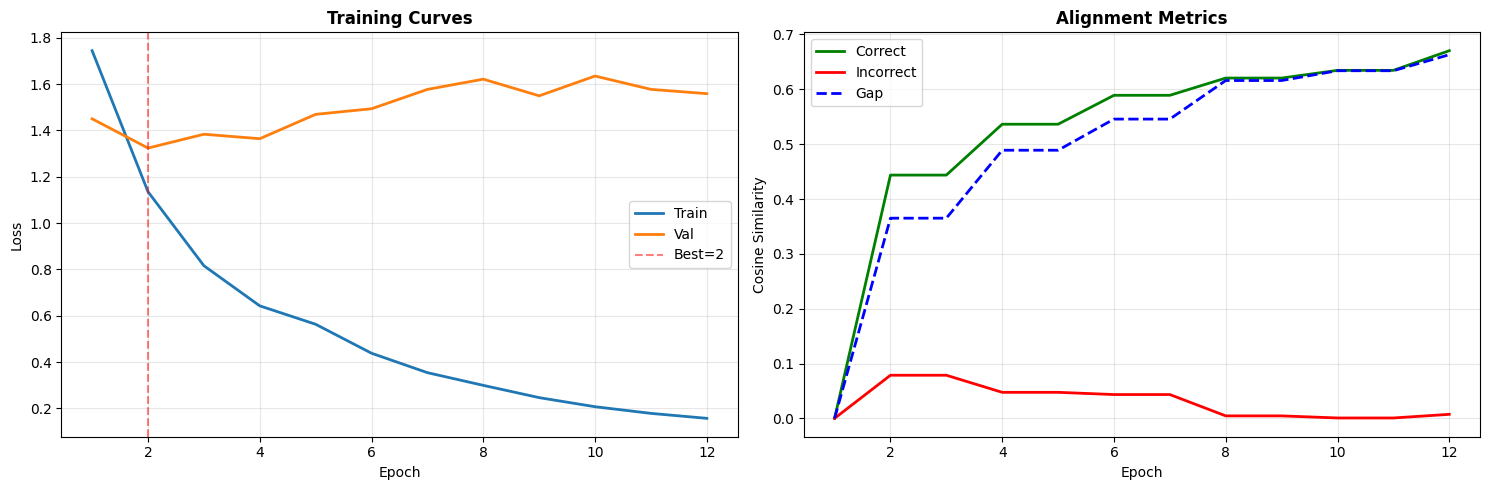


Final gap: 0.663 (target: > 0.5)
Best val loss: 1.3238 at epoch 2


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(train_losses) + 1)
axes[0].plot(epochs, train_losses, label='Train', linewidth=2)
axes[0].plot(epochs, val_losses, label='Val', linewidth=2)
axes[0].axvline(best_epoch, color='red', linestyle='--', label=f'Best={best_epoch}', alpha=0.5)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Curves', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(epochs, cos_correct_hist, label='Correct', linewidth=2, color='green')
axes[1].plot(epochs, cos_wrong_hist, label='Incorrect', linewidth=2, color='red')
gap_hist = [c - w for c, w in zip(cos_correct_hist, cos_wrong_hist)]
axes[1].plot(epochs, gap_hist, label='Gap', linestyle='--', linewidth=2, color='blue')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cosine Similarity')
axes[1].set_title('Alignment Metrics', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(pjoin(Config.SAVE_DIR, 'training_summary.png'), dpi=150)
plt.show()

print(f'\nFinal gap: {gap_hist[-1]:.3f} (target: > 0.5)')
print(f'Best val loss: {best_val_loss:.4f} at epoch {best_epoch}')

## 14. Save/Load

In [ ]:
# SAVE
torch.save(motion_encoder.state_dict(), pjoin(Config.SAVE_DIR, 'motion_encoder.pt'))
torch.save(text_encoder.state_dict(), pjoin(Config.SAVE_DIR, 'text_encoder.pt'))
print('✓ Models saved')

✓ Models saved


In [ ]:
# LOAD
motion_encoder.load_state_dict(torch.load(pjoin(Config.SAVE_DIR, 'motion_encoder.pt')))
text_encoder.load_state_dict(torch.load(pjoin(Config.SAVE_DIR, 'text_encoder.pt')))
print('✓ Models loaded')

✓ Models loaded


## 15. Prédiction

In [ ]:
import pathlib

TOP_K = 10
TEST_DIR = pathlib.Path(pjoin(Config.DATA_ROOT, 'val/'))

text_encoder.eval()
motion_encoder.eval()

submission_rows = []
test_subdirs = sorted([d for d in TEST_DIR.iterdir() if d.is_dir()],
                      key=lambda d: int(d.name))    

with torch.no_grad():
    for sd in tqdm.tqdm(test_subdirs, desc='Génération soumission'):
        query_id = int(sd.name)

        query_file = sd / 'query.txt' if (sd / 'query.txt').exists() else sd / 'text.txt'
        query_text = query_file.read_text('utf-8').strip()

        text_batch = tokenize_texts([query_text])
        text_batch = {k: v.to(device) if v is not None else None for k, v in text_batch.items()}
        text_emb = encode_text(text_batch)

        candidate_files = sorted(sd.glob('motion_*.npy'))
        candidate_ids = [int(f.stem.split('_')[-1]) for f in candidate_files]

        motions, masks = [], []
        for f in candidate_files:
            m, msk = preprocess_motion(np.load(f), GLOBAL_MEAN, GLOBAL_STD)
            motions.append(m)
            masks.append(msk)

        motion_batch = torch.stack(motions).to(device)
        mask_batch = torch.stack(masks).to(device)
        motion_embs = encode_motion(motion_batch, mask_batch)

        sims = (text_emb @ motion_embs.T).squeeze(0)
        k = min(TOP_K, len(candidate_ids))
        top_idx = torch.topk(sims, k=k).indices.cpu().tolist()
        top_ids = [candidate_ids[i] for i in top_idx]

        row = {'query_id': query_id}
        for rank, mid in enumerate(top_ids, start=1):
            row[f'candidate_{rank}'] = mid
        submission_rows.append(row)

cols = ['query_id'] + [f'candidate_{k}' for k in range(1, TOP_K + 1)]
submission_df = pd.DataFrame(submission_rows).reindex(columns=cols)
submission_df.set_index('query_id', inplace=True)

submission_df.to_csv('submission.csv')
print('\n✓ submission.csv generated')
print(submission_df.head())

Génération soumission: 100%|██████████| 30/30 [00:02<00:00, 14.84it/s]


✓ submission.csv generated
          candidate_1  candidate_2  candidate_3  candidate_4  candidate_5  \
query_id                                                                    
1                  18           31            9           13           23   
2                   5           25           21           19           13   
3                  11           24            8           14           31   
4                  19           24           11           29           28   
5                  32            8            4           23            7   

          candidate_6  candidate_7  candidate_8  candidate_9  candidate_10  
query_id                                                                    
1                   3           27           29           12             5  
2                   7           17           20           10            31  
3                  18           27           13           17            12  
4                   7           31           15

## 16. Évaluation

In [ ]:
gt_df = pd.read_csv(pjoin(str(TEST_DIR), 'gt.csv'))
recall = eval_recall(gt_df, submission_df, verbose=True)
print(f'\n🎯 Weighted Recall: {recall:.4f}')

# Log à MLflow
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_metric('final_recall', recall)

k=1 => recall@1=0.633
k=2 => recall@2=0.867
k=3 => recall@3=0.867
k=4 => recall@4=0.9
k=5 => recall@5=0.9
k=6 => recall@6=0.933
k=7 => recall@7=0.933
k=8 => recall@8=0.933
k=9 => recall@9=0.933
k=10 => recall@10=0.967

🎯 Weighted Recall: 0.8080


In [ ]:
gt_df.head()

,query_id,candidate
0,1,18
1,2,5
2,3,11
3,4,19
4,5,8


## 16bis. Prédiction par Ensemble (Vote Multi-Modèles)

Inspiré du **Random Forest** : plusieurs modèles indépendants votent, le résultat final est plus robuste qu'un seul modèle.

### Principe
1. Chaque modèle produit un **classement** des 32 candidats pour chaque query
2. Les classements sont combinés par **Borda count** ou **moyenne des similarités**
3. Le candidat avec le meilleur score agrégé est retenu

### Comment utiliser
1. Entraînez plusieurs modèles (différentes architectures, seeds, hyperparamètres)
2. Sauvegardez les `.pt` sous des noms différents (ex: `run2_motion_best.pt`)
3. Renseignez `ENSEMBLE_MODELS` ci-dessous avec les chemins et poids
4. Choisissez la méthode (`'borda'` recommandé pour modèles de même qualité)

### Méthodes d'agrégation

| Méthode | Description | Quand l'utiliser |
|---|---|---|
| `'borda'` | Score = somme des 1/rang | Modèles de qualités similaires |
| `'mean_sim'` | Moyenne des similarités normalisées | Même espace d'embedding |
| `'weighted_sim'` | Moyenne pondérée par recall de chaque modèle | Modèles de qualités différentes |


In [ ]:
# ================================================================================
# PREDICTION PAR ENSEMBLE - Vote multi-modeles
# ================================================================================
import pathlib, os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd

# ── CONFIGURATION ENSEMBLE ────────────────────────────────────────────────────
# Chaque entree: (chemin_motion_encoder, chemin_text_encoder, poids)
# Poids: utilise pour 'weighted_sim'. Mettre 1.0 pour egalite (borda/mean_sim).
# Vous pouvez avoir autant de modeles que vous voulez (recommande: 3-7)

ENSEMBLE_MODELS = [
    ('./checkpoints/motion_encoder_best.pt', './checkpoints/text_encoder_best.pt', 1.0),
    # Ajoutez vos autres modeles ici :
    # ('./checkpoints/run2_motion_best.pt',  './checkpoints/run2_text_best.pt',   1.0),
    # ('./checkpoints/run3_motion_best.pt',  './checkpoints/run3_text_best.pt',   0.9),
    # ('./checkpoints/run4_motion_best.pt',  './checkpoints/run4_text_best.pt',   1.0),
    # ('./checkpoints/run5_motion_best.pt',  './checkpoints/run5_text_best.pt',   0.8),
]

# Methode: 'borda', 'mean_sim', ou 'weighted_sim'
ENSEMBLE_METHOD  = 'borda'
TOP_K            = 10
TEST_DIR_ENS     = pathlib.Path(pjoin(Config.DATA_ROOT, 'val/'))

print(f"Ensemble: {len(ENSEMBLE_MODELS)} modele(s) | Methode: {ENSEMBLE_METHOD}")


# ── HELPERS ───────────────────────────────────────────────────────────────────

def load_model_pair(motion_path, text_path):
    me = create_motion_encoder().to(device)
    me.load_state_dict(torch.load(motion_path, map_location=device))
    me.eval()

    te = DistilBertTextEncoder(
        output_dim=Config.EMBED_DIM,
        freeze=Config.FREEZE_TEXT_ENCODER,
        dropout=Config.DROPOUT
    ).to(device)
    te.load_state_dict(torch.load(text_path, map_location=device))
    te.eval()
    return me, te


def get_similarities_one_model(me, te, test_subdirs):
    sim_dict = {}
    with torch.no_grad():
        for sd in test_subdirs:
            qid = int(sd.name)
            qf  = sd / 'query.txt' if (sd / 'query.txt').exists() else sd / 'text.txt'
            tb  = tokenize_texts([qf.read_text('utf-8').strip()])
            tb  = {k: v.to(device) if v is not None else None for k, v in tb.items()}
            t_emb = F.normalize(te(**tb), dim=-1)

            cfiles = sorted(sd.glob('motion_*.npy'))
            cids   = [int(f.stem.split('_')[-1]) for f in cfiles]
            motions, masks = [], []
            for f in cfiles:
                m, msk = preprocess_motion(np.load(f), GLOBAL_MEAN, GLOBAL_STD)
                motions.append(m); masks.append(msk)

            m_batch   = torch.stack(motions).to(device)
            msk_batch = torch.stack(masks).to(device)
            m_embs    = F.normalize(me(m_batch, msk_batch), dim=-1)
            sims      = (t_emb @ m_embs.T).squeeze(0).cpu().numpy()
            sim_dict[qid] = {cid: float(s) for cid, s in zip(cids, sims)}
    return sim_dict


def aggregate_borda(all_sims, weights):
    scores = {}
    for qid in all_sims[0]:
        borda = {}
        for sim_d, w in zip(all_sims, weights):
            ranked = sorted(sim_d[qid].items(), key=lambda x: -x[1])
            for rank, (cid, _) in enumerate(ranked, start=1):
                borda[cid] = borda.get(cid, 0.0) + w / rank
        scores[qid] = borda
    return scores


def aggregate_mean_sim(all_sims, weights):
    total_w = sum(weights)
    scores  = {}
    for qid in all_sims[0]:
        combined = {}
        for sim_d, w in zip(all_sims, weights):
            vals  = list(sim_d[qid].values())
            lo, hi = min(vals), max(vals)
            denom  = (hi - lo) if hi != lo else 1.0
            for cid, s in sim_d[qid].items():
                combined[cid] = combined.get(cid, 0.0) + w * (s - lo) / denom
        scores[qid] = {cid: v / total_w for cid, v in combined.items()}
    return scores


def scores_to_df(scores, top_k=10):
    rows = []
    for qid in sorted(scores):
        ranked = sorted(scores[qid].items(), key=lambda x: -x[1])
        row = {'query_id': qid}
        for r, (cid, _) in enumerate(ranked[:top_k], 1):
            row[f'candidate_{r}'] = cid
        rows.append(row)
    cols = ['query_id'] + [f'candidate_{k}' for k in range(1, top_k + 1)]
    df = pd.DataFrame(rows).reindex(columns=cols).set_index('query_id')
    return df


# ── PIPELINE ──────────────────────────────────────────────────────────────────
test_dirs = sorted([d for d in TEST_DIR_ENS.iterdir() if d.is_dir()], key=lambda d: int(d.name))
all_sims  = []
weights   = []

for idx, (mp, tp, w) in enumerate(ENSEMBLE_MODELS, 1):
    if not pathlib.Path(mp).exists():
        print(f"  Modele {idx} introuvable: {mp} - ignore")
        continue
    print(f"  Modele {idx}/{len(ENSEMBLE_MODELS)}: {mp}")
    me_i, te_i = load_model_pair(mp, tp)
    all_sims.append(get_similarities_one_model(me_i, te_i, test_dirs))
    weights.append(w)
    del me_i, te_i
    torch.cuda.empty_cache()

if not all_sims:
    raise RuntimeError("Aucun modele charge. Verifiez les chemins dans ENSEMBLE_MODELS.")

print(f"\n{len(all_sims)} modele(s). Aggregation: '{ENSEMBLE_METHOD}'...")

if ENSEMBLE_METHOD == 'borda':
    agg = aggregate_borda(all_sims, weights)
else:
    agg = aggregate_mean_sim(all_sims, weights)

ensemble_df = scores_to_df(agg, top_k=TOP_K)
ensemble_df.to_csv('submission_ensemble.csv')
print(f"\n✓ submission_ensemble.csv ({len(ensemble_df)} queries)")
print(ensemble_df.head())


### Évaluation de l'Ensemble

In [ ]:
# Evaluation de l'ensemble sur le val set
gt_ens   = pd.read_csv(pjoin(str(TEST_DIR_ENS), 'gt.csv'))
r_ens    = eval_recall(gt_ens, ensemble_df, verbose=True)
print(f'\n Ensemble Weighted Recall: {r_ens:.4f}')
try:
    delta = r_ens - recall
    sign  = '+' if delta >= 0 else ''
    print(f'   vs modele seul: {recall:.4f}  (delta: {sign}{delta:.4f})')
    if delta > 0:
        print('   Ensemble ameliore le resultat !')
    else:
        print('   Ensemble moins bon - verifiez la diversite des modeles')
except NameError:
    print('   (lancez la cellule prediction standard pour comparer)')


## 17. Reprise d'entraînement (Resume Training)

**Procédure :**
1. Notez le Run ID MLflow affiché en fin d'entraînement
2. Collez-le dans `RESUME_RUN_ID` ci-dessous
3. Exécutez les cellules 5, 6, 10 (encodeurs + optimiseur)
4. Exécutez cette cellule
5. Relancez **uniquement** la cellule 12 (Training Loop)

**Early stopping mode :** modifiez `EARLY_STOPPING_MODE` dans la Config (cellule 0).
- `'recall'` ← recommandé si val loss stagne mais recall monte encore
- `'val_loss'` ← comportement classique

**Fichiers checkpoint :**
- `checkpoints/checkpoint_latest.pt` — sauvegardé automatiquement chaque epoch
- `checkpoints/motion_encoder_best.pt` / `text_encoder_best.pt` — meilleur modèle


In [ ]:
# ================================================================================
# REPRISE D'ENTRAINEMENT
# 1. Coller votre Run ID MLflow dans RESUME_RUN_ID
# 2. Executer cette cellule
# 3. Relancer la cellule 12 (Training Loop)
# ================================================================================

RESUME_RUN_ID = ''   # ex: 'abc123def456...'

import os
checkpoint_path = pjoin(Config.SAVE_DIR, 'checkpoint_latest.pt')

if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(
        f'Checkpoint introuvable: {checkpoint_path}\n'
        f"SAVE_DIR='{Config.SAVE_DIR}' — verifiez le bon dossier.\n"
        'Le checkpoint est cree automatiquement a la fin de chaque epoch.'
    )

print('Chargement du checkpoint...')
ckpt = torch.load(checkpoint_path, map_location=device)

motion_encoder.load_state_dict(ckpt['motion_encoder_state'])
text_encoder.load_state_dict(ckpt['text_encoder_state'])
optimizer.load_state_dict(ckpt['optimizer_state'])
scheduler.load_state_dict(ckpt['scheduler_state'])

start_epoch      = ckpt['epoch'] + 1
train_losses     = ckpt['train_losses']
val_losses       = ckpt['val_losses']
cos_correct_hist = ckpt['cos_correct_hist']
cos_wrong_hist   = ckpt['cos_wrong_hist']
best_val_loss    = ckpt['best_val_loss']
best_recall      = ckpt.get('best_recall', 0.0)
best_epoch       = ckpt['best_epoch']
global_step      = ckpt['global_step']

_saved   = RESUME_RUN_ID or ckpt.get('run_id', '')
_existing_run_id = _saved if _saved else None

print(f'Reprise depuis epoch {ckpt["epoch"]} -> epoch {start_epoch} jusqu\'a {Config.EPOCHS}')
print(f'Best recall: {best_recall:.3f} | Best val loss: {best_val_loss:.4f}')
if _existing_run_id:
    print(f'MLflow run ID: {_existing_run_id}')
else:
    print('Nouveau run MLflow cree (pas de RESUME_RUN_ID)')
print('-> Relancez maintenant la cellule 12 (Training Loop)')
